Tutorial 7: We show in this tutorial how to use MrBeam and DoG-HiT to do polarimetry. To do polarized imaging, we first do Stokes I imaging: let us repeat the steps from tutorial 6.

In [1]:
#-------------------------------------------------------------------------------
# Modules
#-------------------------------------------------------------------------------
import ehtim as eh
import numpy as np
import matplotlib.pyplot as plt

from imagingbase.ehtim_calibration import Calibrator
from imagingbase.minimization_handler import MinimizationHandler
from imagingbase.polimaging import PolHandler
from imagingbase.ehtim_wrapper_pol import EhtimWrapperPol
from imagingbase.solvers.scipy_solver import Minimize

import ehtplot.color
cfun = 'afmhot_u'

import pathlib 
current_path = str(pathlib.Path().absolute())

import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(name)-20s :: %(message)s'
)

Welcome to eht-imaging! v 1.2.4 



In [2]:
#-------------------------------------------------------------------------------
# Synthetic observation
#-------------------------------------------------------------------------------

# Load the image and the array
im = eh.image.load_txt(r'/homes/hmueller/eht-imaging-main/models/avery_sgra_eofn.txt')
eht = eh.array.load_txt(r'/homes/hmueller/eht-imaging-main/arrays/EHT2017.txt')

# Observe the image
tint_sec = 5
tadv_sec = 600
tstart_hr = 0
tstop_hr = 24
bw_hz = 400e9
obs = im.observe(eht, tint_sec, tadv_sec, tstart_hr, tstop_hr, bw_hz,
                 sgrscat=False, ampcal=True, phasecal=True, add_th_noise=True, ttype='direct')

Loading text image:  /homes/hmueller/eht-imaging-main/models/avery_sgra_eofn.txt
Generating empty observation file . . . 
Producing clean visibilities from image with direct FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Adding thermal noise to data . . . 


In [3]:
#-------------------------------------------------------------------------------
# Fixed imaging parameters
#-------------------------------------------------------------------------------
ttype     = 'direct'            # Type of Fourier transform ('direct', 'nfft', or 'fast')

zbl       = im.total_flux()                 # Total compact flux density (Jy)
npix      = 64                 # Number of pixels across the reconstructed image
fov       = 256*eh.RADPERUAS    # Field of view of the reconstructed image

prior_fwhm = 200.0*eh.RADPERUAS  # Gaussian prior FWHM (radians)
sys_noise  = 0.02               # fractional systematic noise
                                # added to complex visibilities
                                                               
#data weights
data_term = {'amp'    : 0.2,    # visibility amplitudes
             'cphase' : 1.0,    # closure phases
             'logcamp': 1.0}    # log closure amplitudes

stop      = 1e-8                # Imager stopping criterion
gain_tol  = [0.02,0.2]          # Asymmetric gain tolerance for self-cal; we expect larger values
                                # for unaccounted sensitivity loss
                                # than for unaccounted sensitivity improvement
uv_zblcut = 0.1e9               # uv-distance that separates the inter-site "zero"-baselines
                                # from intra-site baselines
zero_baseline = ['AA', 'AP']    # baseline to measure zero-spacing flux
rescaling = 0.001              # rescale intensities per pixel to obtain values of the order ~1

cbar_lims = [0, 25*10**9]       #cbar-lims for interactive plotting (brightness temperature)

In [4]:
#-------------------------------------------------------------------------------
# Prepare the data
#-------------------------------------------------------------------------------
zero_baseline = ['ALMA', 'APEX']
cal = Calibrator(obs, zero_baseline, zbl, uv_zblcut, 0, sys_noise)
cal.prepare_data()

#-------------------------------------------------------------------------------
# Pre-calibrate the data
#-------------------------------------------------------------------------------

res    = cal.obs.res()  # The nominal array resolution: 1/(longest baseline)

# Make a Gaussian prior image for maximum entropy regularization
# This Gaussian is also the initial image
gaussprior = eh.image.make_square(cal.obs, npix, fov)
gaussprior = gaussprior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))

# To avoid gradient singularities in the first step, add an additional small Gaussians
gaussprior = gaussprior.add_gauss(zbl*1e-3, (prior_fwhm, prior_fwhm, 0, prior_fwhm, prior_fwhm))

cal.precalibrate_data()

obs_sc = cal.obs_sc

/aux/vlb051a/anaconda3/envs/mrbeam/lib/python3.10/site-packages/ehtim/obsdata.py:509: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


In [5]:
#------------------------------------------------------------------------------
# Prepare Minimization Procedure
#------------------------------------------------------------------------------
#clean beam fwhm
psf_fwhm = 20*eh.RADPERUAS

#threshold for identifying gaps in uv-coverage
threshold = 0.15*10**9
#add short baselines wavelets 
short_bl_wl=[20, 23.7]
#add long baseline wavelets
long_bl_wl=[]
#the final handler for the minimization procedure
handler = MinimizationHandler(psf_fwhm, npix, fov, obs_sc, gaussprior, zbl, rescaling, data_term, cbar_lims, threshold, short_bl_wl, long_bl_wl) 
#widths of wavelet filters
widths = handler.widths

Generating I image...
Generating I image...
Generating I image...
Generating I image...


Round 1: Unconstrained Imaging with visibility amplitudes and closure quantities ...
Initializing imager data products . . .
U-V flagged 125/1030 visibilities
U-V flagged 905/1030 visibilities
Imager run 1 
time: 3.081961 s
J: 30.383236
chi2_amp : 97.56 chi2_cphase : 4.53 chi2_logcamp : 8.16 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 2 
time: 3.058167 s
J: 3.090924
chi2_amp : 15.93 chi2_cphase : 0.94 chi2_logcamp : 1.16 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 3 
time: 3.114738 s
J: 0.064314
chi2_amp : 7.47 chi2_cphase : 0.29 chi2_logcamp : 0.47 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 4 
time: 3.184521 s
J: -0.812262
chi2_amp : 4.45 chi2_cphase : 0.19 chi2_logcamp : 0.31 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 5 
time: 3.365436 s
J: -1.186980
chi2_amp : 3.40 chi2_cphase : 0.13 chi2_logcamp : 0.20 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 6 
time: 3.648066 s
J: -1.429299
chi2_amp : 2.39 chi2_cphase : 0.12 chi2_log

time: 0.295521 s
J: -1.829563
chi2_amp : 0.96 chi2_cphase : 0.08 chi2_logcamp : 0.10 
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Imager run 41 
time: 0.252086 s
J: -1.829781
chi2_amp : 0.96 chi2_cphase : 0.08 chi2_logcamp : 0.10 
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Imager run 42 
time: 0.254276 s
J: -1.829959
chi2_amp : 0.96 chi2_cphase : 0.08 chi2_logcamp : 0.10 
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Imager run 43 
time: 0.245043 s
J: -1.830099
chi2_amp : 0.96 chi2_cphase : 0.08 chi2_logcamp : 0.10 
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Imager run 44 
time: 0.264287 s
J: -1.830242
chi2_amp : 0.96 chi2_cphase : 0.08 chi2_logcamp : 0.10 
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Imager run 45 
time: 2.655307 s
J: -1.276717
chi2_amp : 1.75 chi2_cphase : 0.29 chi2_logcamp : 0.28 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 46 
time: 2.760439 s
J: -1.685367
chi2_amp : 1.30 chi2_cphase : 0.11 chi2_logcamp : 0.14 
STOP: TOTAL NO. of ITERA

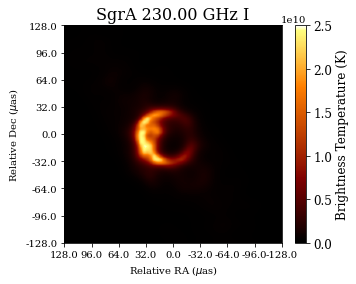

No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 106/107 : [----------------------------- ]99%
self_cal time: 11.380028 s


/aux/vlb051a/anaconda3/envs/mrbeam/lib/python3.10/site-packages/ehtim/obsdata.py:509: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


In [6]:
#------------------------------------------------------------------------------
# First round of imaging: Unconstrained ehtim reconstruction
# alternating imaging and blurring to help global convergence
#------------------------------------------------------------------------------
print("Round 1: Unconstrained Imaging with visibility amplitudes and closure quantities ...")

#run minimization
img = handler.first_round(gaussprior, data_term, cycles=5)

img.display(cbar_unit=['Tb'], cfun=cfun, cbar_lims=cbar_lims)

#phase-calibration
obs_sc = eh.selfcal(obs_sc, img, method='phase', ttype=ttype)
handler.updateobs(obs_sc.copy())

Round 2: Multiscalar Imaging with closure quantities ...
We use  4 scales with threshold 1.5
Current minimum 106.43609787091168
Start optimization with thresholds [1.5 1.5 1.5 1.5 1.5]
reverse mode: True
Updated at scale 0 to threshold 2.0 to minimum 105.89586754437192
Updated at scale 0 to threshold 2.5 to minimum 104.87148474778539
Updated at scale 0 to threshold 3.0 to minimum 104.05527591806045
Updated at scale 0 to threshold 3.5 to minimum 103.67385893459168
Updated at scale 0 to threshold 5.0 to minimum 103.16591083523484
Updated at scale 0 to threshold 6.0 to minimum 103.06780197630658
Updated at scale 0 to threshold 6.5 to minimum 102.88291167550814
Updated at scale 1 to threshold 2.0 to minimum 102.01315872887244
Updated at scale 1 to threshold 2.5 to minimum 98.87346324183373
Updated at scale 2 to threshold 0.0 to minimum 96.8895967040765
Updated at scale 2 to threshold 0.5 to minimum 93.33577463872393
Updated at scale 3 to threshold 0.0 to minimum 90.15783602849496
Updated a

2022-08-05 13:27:35,240 INFO CountIterations      :: iteration = 1 / 25
2022-08-05 13:27:35,242 INFO Display              :: Penalty--> 38.09825428043851


We use thresholds:  [6.5 2.5 0.5 0.  0. ]


2022-08-05 13:27:35,369 INFO CountIterations      :: iteration = 2 / 25
2022-08-05 13:27:35,371 INFO Display              :: Penalty--> 38.093808376268576
2022-08-05 13:27:35,496 INFO CountIterations      :: iteration = 3 / 25
2022-08-05 13:27:35,498 INFO Display              :: Penalty--> 38.091267859600045
2022-08-05 13:27:35,621 INFO CountIterations      :: iteration = 4 / 25
2022-08-05 13:27:35,626 INFO Display              :: Penalty--> 38.088092213764384
2022-08-05 13:27:35,756 INFO CountIterations      :: iteration = 5 / 25
2022-08-05 13:27:35,758 INFO Display              :: Penalty--> 38.08555169709585
2022-08-05 13:27:35,875 INFO CountIterations      :: iteration = 6 / 25
2022-08-05 13:27:35,877 INFO Display              :: Penalty--> 38.08364630959446
2022-08-05 13:27:36,060 INFO CountIterations      :: iteration = 7 / 25
2022-08-05 13:27:36,060 INFO Display              :: Penalty--> 38.081740922093054
2022-08-05 13:27:36,167 INFO CountIterations      :: iteration = 8 / 25


2354.1737471914016
Data Fidelity:  5.205465668966285


2022-08-05 13:27:38,420 INFO CountIterations      :: iteration = 2 / 25
2022-08-05 13:27:38,422 INFO Display              :: Penalty--> 37.20654592532095
2022-08-05 13:27:38,538 INFO CountIterations      :: iteration = 3 / 25
2022-08-05 13:27:38,540 INFO Display              :: Penalty--> 37.20654592532095
2022-08-05 13:27:38,653 INFO CountIterations      :: iteration = 4 / 25
2022-08-05 13:27:38,655 INFO Display              :: Penalty--> 37.20654592532095
2022-08-05 13:27:38,768 INFO CountIterations      :: iteration = 5 / 25
2022-08-05 13:27:38,770 INFO Display              :: Penalty--> 37.20654592532095
2022-08-05 13:27:38,884 INFO CountIterations      :: iteration = 6 / 25
2022-08-05 13:27:38,886 INFO Display              :: Penalty--> 37.08678056745261
2022-08-05 13:27:39,060 INFO CountIterations      :: iteration = 7 / 25
2022-08-05 13:27:39,062 INFO Display              :: Penalty--> 37.08678056745261
2022-08-05 13:27:39,244 INFO CountIterations      :: iteration = 8 / 25
2022

2481.430272503477
Data Fidelity:  3.74250426212312


2022-08-05 13:27:41,620 INFO CountIterations      :: iteration = 2 / 25
2022-08-05 13:27:41,622 INFO Display              :: Penalty--> 36.42527641907453
2022-08-05 13:27:41,744 INFO CountIterations      :: iteration = 3 / 25
2022-08-05 13:27:41,746 INFO Display              :: Penalty--> 36.418991511736955
2022-08-05 13:27:41,874 INFO CountIterations      :: iteration = 4 / 25
2022-08-05 13:27:41,876 INFO Display              :: Penalty--> 36.41742028490256
2022-08-05 13:27:42,004 INFO CountIterations      :: iteration = 5 / 25
2022-08-05 13:27:42,006 INFO Display              :: Penalty--> 36.41394367056677
2022-08-05 13:27:42,123 INFO CountIterations      :: iteration = 6 / 25
2022-08-05 13:27:42,125 INFO Display              :: Penalty--> 36.40859486089645
2022-08-05 13:27:42,232 INFO CountIterations      :: iteration = 7 / 25
2022-08-05 13:27:42,234 INFO Display              :: Penalty--> 36.4041821488934
2022-08-05 13:27:42,352 INFO CountIterations      :: iteration = 8 / 25
2022

2467.931291662041
Data Fidelity:  2.998385442532144


2022-08-05 13:27:44,824 INFO CountIterations      :: iteration = 2 / 25
2022-08-05 13:27:44,826 INFO Display              :: Penalty--> 36.33932811151562
2022-08-05 13:27:44,940 INFO CountIterations      :: iteration = 3 / 25
2022-08-05 13:27:44,942 INFO Display              :: Penalty--> 36.331471977343654
2022-08-05 13:27:45,068 INFO CountIterations      :: iteration = 4 / 25
2022-08-05 13:27:45,070 INFO Display              :: Penalty--> 36.328630492175
2022-08-05 13:27:45,186 INFO CountIterations      :: iteration = 5 / 25
2022-08-05 13:27:45,188 INFO Display              :: Penalty--> 36.32391681167182
2022-08-05 13:27:45,305 INFO CountIterations      :: iteration = 6 / 25
2022-08-05 13:27:45,307 INFO Display              :: Penalty--> 36.32044019733602
2022-08-05 13:27:45,425 INFO CountIterations      :: iteration = 7 / 25
2022-08-05 13:27:45,426 INFO Display              :: Penalty--> 36.31352016083132
2022-08-05 13:27:45,545 INFO CountIterations      :: iteration = 8 / 25
2022-

2471.4890991436123
Data Fidelity:  2.5406621394300823


2022-08-05 13:27:47,854 INFO CountIterations      :: iteration = 1 / 25
2022-08-05 13:27:47,858 INFO Display              :: Penalty--> 36.13729596693043
2022-08-05 13:27:47,995 INFO CountIterations      :: iteration = 2 / 25
2022-08-05 13:27:47,997 INFO Display              :: Penalty--> 36.13572474009604
2022-08-05 13:27:48,131 INFO CountIterations      :: iteration = 3 / 25
2022-08-05 13:27:48,133 INFO Display              :: Penalty--> 36.133518384094515
2022-08-05 13:27:48,343 INFO CountIterations      :: iteration = 4 / 25
2022-08-05 13:27:48,345 INFO Display              :: Penalty--> 36.12816957442419
2022-08-05 13:27:48,463 INFO CountIterations      :: iteration = 5 / 25
2022-08-05 13:27:48,466 INFO Display              :: Penalty--> 36.12188466708662
2022-08-05 13:27:48,582 INFO CountIterations      :: iteration = 6 / 25
2022-08-05 13:27:48,583 INFO Display              :: Penalty--> 36.117471955083566
2022-08-05 13:27:48,701 INFO CountIterations      :: iteration = 7 / 25
20

2469.1244809978266
Data Fidelity:  2.1842153759052803


2022-08-05 13:27:51,417 INFO CountIterations      :: iteration = 2 / 25
2022-08-05 13:27:51,419 INFO Display              :: Penalty--> 35.77436540981458
2022-08-05 13:27:51,530 INFO CountIterations      :: iteration = 3 / 25
2022-08-05 13:27:51,532 INFO Display              :: Penalty--> 35.77122295614579
2022-08-05 13:27:51,643 INFO CountIterations      :: iteration = 4 / 25
2022-08-05 13:27:51,645 INFO Display              :: Penalty--> 35.76901660014427
2022-08-05 13:27:51,757 INFO CountIterations      :: iteration = 5 / 25
2022-08-05 13:27:51,759 INFO Display              :: Penalty--> 35.76587414647548
2022-08-05 13:27:51,869 INFO CountIterations      :: iteration = 6 / 25
2022-08-05 13:27:51,871 INFO Display              :: Penalty--> 35.762731692806696
2022-08-05 13:27:51,983 INFO CountIterations      :: iteration = 7 / 25
2022-08-05 13:27:51,985 INFO Display              :: Penalty--> 35.75895410997077
2022-08-05 13:27:52,097 INFO CountIterations      :: iteration = 8 / 25
202

2473.506964185117
Data Fidelity:  1.9568183059133586


2022-08-05 13:27:54,477 INFO CountIterations      :: iteration = 2 / 25
2022-08-05 13:27:54,478 INFO Display              :: Penalty--> 35.580589944402114
2022-08-05 13:27:54,650 INFO CountIterations      :: iteration = 3 / 25
2022-08-05 13:27:54,651 INFO Display              :: Penalty--> 35.57901871756772
2022-08-05 13:27:54,803 INFO CountIterations      :: iteration = 4 / 25
2022-08-05 13:27:54,804 INFO Display              :: Penalty--> 35.575876263898934
2022-08-05 13:27:54,919 INFO CountIterations      :: iteration = 5 / 25
2022-08-05 13:27:54,921 INFO Display              :: Penalty--> 35.575241134731804
2022-08-05 13:27:55,038 INFO CountIterations      :: iteration = 6 / 25
2022-08-05 13:27:55,040 INFO Display              :: Penalty--> 35.57303477873028
2022-08-05 13:27:55,158 INFO CountIterations      :: iteration = 7 / 25
2022-08-05 13:27:55,159 INFO Display              :: Penalty--> 35.57082842272875
2022-08-05 13:27:55,276 INFO CountIterations      :: iteration = 8 / 25
2

2475.3280434225244
Data Fidelity:  1.7622752140213809


2022-08-05 13:27:57,872 INFO CountIterations      :: iteration = 1 / 25
2022-08-05 13:27:57,874 INFO Display              :: Penalty--> 35.3812735453316
2022-08-05 13:27:57,993 INFO CountIterations      :: iteration = 2 / 25
2022-08-05 13:27:57,996 INFO Display              :: Penalty--> 35.37970231849721
2022-08-05 13:27:58,118 INFO CountIterations      :: iteration = 3 / 25
2022-08-05 13:27:58,120 INFO Display              :: Penalty--> 35.37843206016294
2022-08-05 13:27:58,242 INFO CountIterations      :: iteration = 4 / 25
2022-08-05 13:27:58,244 INFO Display              :: Penalty--> 35.37622570416142
2022-08-05 13:27:58,393 INFO CountIterations      :: iteration = 5 / 25
2022-08-05 13:27:58,395 INFO Display              :: Penalty--> 35.374955445827155
2022-08-05 13:27:58,511 INFO CountIterations      :: iteration = 6 / 25
2022-08-05 13:27:58,513 INFO Display              :: Penalty--> 35.374955445827155
2022-08-05 13:27:58,641 INFO CountIterations      :: iteration = 7 / 25
202

2474.596748963925
Data Fidelity:  1.6178454504298783


2022-08-05 13:28:01,410 INFO CountIterations      :: iteration = 1 / 25
2022-08-05 13:28:01,411 INFO Display              :: Penalty--> 35.21173128926229
2022-08-05 13:28:01,522 INFO CountIterations      :: iteration = 2 / 25
2022-08-05 13:28:01,524 INFO Display              :: Penalty--> 35.21173128926229
2022-08-05 13:28:01,635 INFO CountIterations      :: iteration = 3 / 25
2022-08-05 13:28:01,637 INFO Display              :: Penalty--> 35.210160062427896
2022-08-05 13:28:01,748 INFO CountIterations      :: iteration = 4 / 25
2022-08-05 13:28:01,750 INFO Display              :: Penalty--> 35.20638247959197
2022-08-05 13:28:01,914 INFO CountIterations      :: iteration = 5 / 25
2022-08-05 13:28:01,917 INFO Display              :: Penalty--> 35.203240025923186
2022-08-05 13:28:02,012 INFO CountIterations      :: iteration = 6 / 25
2022-08-05 13:28:02,014 INFO Display              :: Penalty--> 35.20260489675606
2022-08-05 13:28:02,110 INFO CountIterations      :: iteration = 7 / 25
20

2478.2530479674824
Data Fidelity:  1.5057204778159987


2022-08-05 13:28:04,565 INFO CountIterations      :: iteration = 2 / 25
2022-08-05 13:28:04,567 INFO Display              :: Penalty--> 35.16760416923176
2022-08-05 13:28:04,678 INFO CountIterations      :: iteration = 3 / 25
2022-08-05 13:28:04,680 INFO Display              :: Penalty--> 35.16696904006463
2022-08-05 13:28:04,793 INFO CountIterations      :: iteration = 4 / 25
2022-08-05 13:28:04,795 INFO Display              :: Penalty--> 35.16696904006463
2022-08-05 13:28:04,905 INFO CountIterations      :: iteration = 5 / 25
2022-08-05 13:28:04,907 INFO Display              :: Penalty--> 35.16696904006463
2022-08-05 13:28:05,018 INFO CountIterations      :: iteration = 6 / 25
2022-08-05 13:28:05,020 INFO Display              :: Penalty--> 35.16696904006463
2022-08-05 13:28:05,131 INFO CountIterations      :: iteration = 7 / 25
2022-08-05 13:28:05,133 INFO Display              :: Penalty--> 35.16068413272705
2022-08-05 13:28:05,245 INFO CountIterations      :: iteration = 8 / 25
2022

2480.8123357656787
Data Fidelity:  1.4192747495856666


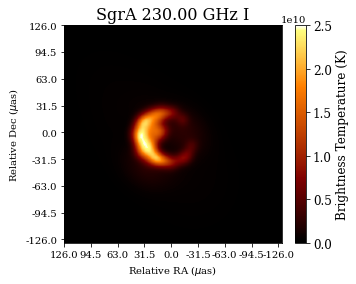

No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 106/107 : [----------------------------- ]99%
self_cal time: 11.489637 s


/aux/vlb051a/anaconda3/envs/mrbeam/lib/python3.10/site-packages/ehtim/obsdata.py:509: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


In [7]:
#-------------------------
# Second Round of Imaging: closure-quantities + sparsity penalization + total flux constraint
#-------------------------

print("Round 2: Multiscalar Imaging with closure quantities ...")

alpha=0.5 #wavelet sparsity constraint
tau=10 #stepsize in minimization

#run mminimization
wtfcts, img = handler.second_round_minimization(img.copy(), alpha, tau, maxiter=10)

img.display(cbar_unit=['Tb'], cfun=cfun, cbar_lims=cbar_lims)

#phase-calibration
obs_sc = eh.selfcal(obs_sc, img, method='phase', ttype=ttype)
handler.updateobs(obs_sc.copy())

Now we have a Stokes I representation of the image. Recall from tutorial 5 and tutorial 6 that DoG-HiT computes the multiresolution support as a byproduct. We used this information before to refine the Stokes I imaging. Now we use the same prior information (only changing coefficients in the multiresolution support) to do polarized imaging for Q and U.

Similarly to Stokes I imaging, we first define a wrapper object for the polarized quantities. Then we define the minimization handler for polarized quantities. Note that the multiscale dictionary (handler.op), the multiresolution support (handler.mask) are already stored in the handler object. So we just copy over these properties.

In the moment only pol_prim='qu' and pol_solve=(1,1,1) are supported.

In [8]:
wrapper = EhtimWrapperPol(obs_sc, img.regrid_image(fov, npix+1), img.regrid_image(fov, npix+1), zbl, d='pvis', clipfloor=-100, pol_solve=(1,1,1), pol_prim='qu')
pol = PolHandler(wrapper, handler.mask, handler.op, wtfcts*rescaling)

Generating I image...
No polarimetric image in the initial image!


Now we are ready to do Stokes Q and U imaging with a gradient descent algorithm. The initial guess and the objective functional and Hilbert Space Setting are allocated by the PolHandler under pol.final_init, pol.final_func and pol.final_setting.

2022-08-05 13:36:02,561 INFO CountIterations      :: iteration = 1 / 1000
2022-08-05 13:36:02,582 INFO Display              :: Data Fidelity--> 18.165925834672887
2022-08-05 13:36:02,957 INFO CountIterations      :: iteration = 2 / 1000
2022-08-05 13:36:02,980 INFO Display              :: Data Fidelity--> 14.91932549616482
2022-08-05 13:36:03,345 INFO CountIterations      :: iteration = 3 / 1000
2022-08-05 13:36:03,370 INFO Display              :: Data Fidelity--> 12.645907506113646
2022-08-05 13:36:03,735 INFO CountIterations      :: iteration = 4 / 1000
2022-08-05 13:36:03,759 INFO Display              :: Data Fidelity--> 10.996997702590399
2022-08-05 13:36:04,124 INFO CountIterations      :: iteration = 5 / 1000
2022-08-05 13:36:04,148 INFO Display              :: Data Fidelity--> 9.759391981979693
2022-08-05 13:36:04,512 INFO CountIterations      :: iteration = 6 / 1000
2022-08-05 13:36:04,536 INFO Display              :: Data Fidelity--> 8.80009074523815
2022-08-05 13:36:04,902 IN

2022-08-05 13:36:22,237 INFO Display              :: Data Fidelity--> 1.845143108509311
2022-08-05 13:36:22,599 INFO CountIterations      :: iteration = 52 / 1000
2022-08-05 13:36:22,625 INFO Display              :: Data Fidelity--> 1.8169445729459854
2022-08-05 13:36:23,030 INFO CountIterations      :: iteration = 53 / 1000
2022-08-05 13:36:23,054 INFO Display              :: Data Fidelity--> 1.78976419688629
2022-08-05 13:36:23,414 INFO CountIterations      :: iteration = 54 / 1000
2022-08-05 13:36:23,439 INFO Display              :: Data Fidelity--> 1.7635443943175062
2022-08-05 13:36:23,801 INFO CountIterations      :: iteration = 55 / 1000
2022-08-05 13:36:23,826 INFO Display              :: Data Fidelity--> 1.7382315801549977
2022-08-05 13:36:24,185 INFO CountIterations      :: iteration = 56 / 1000
2022-08-05 13:36:24,212 INFO Display              :: Data Fidelity--> 1.7137758591007517
2022-08-05 13:36:24,572 INFO CountIterations      :: iteration = 57 / 1000
2022-08-05 13:36:24

2022-08-05 13:36:42,202 INFO CountIterations      :: iteration = 102 / 1000
2022-08-05 13:36:42,224 INFO Display              :: Data Fidelity--> 1.0703838215362824
2022-08-05 13:36:42,598 INFO CountIterations      :: iteration = 103 / 1000
2022-08-05 13:36:42,621 INFO Display              :: Data Fidelity--> 1.061959018672937
2022-08-05 13:36:43,068 INFO CountIterations      :: iteration = 104 / 1000
2022-08-05 13:36:43,098 INFO Display              :: Data Fidelity--> 1.0536659298574311
2022-08-05 13:36:43,477 INFO CountIterations      :: iteration = 105 / 1000
2022-08-05 13:36:43,501 INFO Display              :: Data Fidelity--> 1.0455012303659328
2022-08-05 13:36:43,875 INFO CountIterations      :: iteration = 106 / 1000
2022-08-05 13:36:43,897 INFO Display              :: Data Fidelity--> 1.0374617238553852
2022-08-05 13:36:44,273 INFO CountIterations      :: iteration = 107 / 1000
2022-08-05 13:36:44,296 INFO Display              :: Data Fidelity--> 1.0295443356754286
2022-08-05 

2022-08-05 13:37:01,871 INFO CountIterations      :: iteration = 152 / 1000
2022-08-05 13:37:01,895 INFO Display              :: Data Fidelity--> 0.7652978669898465
2022-08-05 13:37:02,259 INFO CountIterations      :: iteration = 153 / 1000
2022-08-05 13:37:02,283 INFO Display              :: Data Fidelity--> 0.7609353136839425
2022-08-05 13:37:02,647 INFO CountIterations      :: iteration = 154 / 1000
2022-08-05 13:37:02,671 INFO Display              :: Data Fidelity--> 0.756621750109377
2022-08-05 13:37:03,035 INFO CountIterations      :: iteration = 155 / 1000
2022-08-05 13:37:03,058 INFO Display              :: Data Fidelity--> 0.752356403281382
2022-08-05 13:37:03,422 INFO CountIterations      :: iteration = 156 / 1000
2022-08-05 13:37:03,445 INFO Display              :: Data Fidelity--> 0.7481385169980657
2022-08-05 13:37:03,811 INFO CountIterations      :: iteration = 157 / 1000
2022-08-05 13:37:03,864 INFO Display              :: Data Fidelity--> 0.7439673513439908
2022-08-05 1

2022-08-05 13:37:21,363 INFO CountIterations      :: iteration = 202 / 1000
2022-08-05 13:37:21,386 INFO Display              :: Data Fidelity--> 0.5950810685717937
2022-08-05 13:37:21,750 INFO CountIterations      :: iteration = 203 / 1000
2022-08-05 13:37:21,774 INFO Display              :: Data Fidelity--> 0.5924657375633676
2022-08-05 13:37:22,138 INFO CountIterations      :: iteration = 204 / 1000
2022-08-05 13:37:22,162 INFO Display              :: Data Fidelity--> 0.5898746442058231
2022-08-05 13:37:22,526 INFO CountIterations      :: iteration = 205 / 1000
2022-08-05 13:37:22,550 INFO Display              :: Data Fidelity--> 0.5873074852844924
2022-08-05 13:37:22,915 INFO CountIterations      :: iteration = 206 / 1000
2022-08-05 13:37:22,938 INFO Display              :: Data Fidelity--> 0.5847639624640555
2022-08-05 13:37:23,304 INFO CountIterations      :: iteration = 207 / 1000
2022-08-05 13:37:23,327 INFO Display              :: Data Fidelity--> 0.5822437821886111
2022-08-05

2022-08-05 13:37:40,814 INFO CountIterations      :: iteration = 252 / 1000
2022-08-05 13:37:40,838 INFO Display              :: Data Fidelity--> 0.48900879137122294
2022-08-05 13:37:41,203 INFO CountIterations      :: iteration = 253 / 1000
2022-08-05 13:37:41,227 INFO Display              :: Data Fidelity--> 0.4873109380202158
2022-08-05 13:37:41,592 INFO CountIterations      :: iteration = 254 / 1000
2022-08-05 13:37:41,615 INFO Display              :: Data Fidelity--> 0.48562663896672126
2022-08-05 13:37:41,980 INFO CountIterations      :: iteration = 255 / 1000
2022-08-05 13:37:42,004 INFO Display              :: Data Fidelity--> 0.4839557491487181
2022-08-05 13:37:42,369 INFO CountIterations      :: iteration = 256 / 1000
2022-08-05 13:37:42,392 INFO Display              :: Data Fidelity--> 0.4822981254455571
2022-08-05 13:37:42,757 INFO CountIterations      :: iteration = 257 / 1000
2022-08-05 13:37:42,781 INFO Display              :: Data Fidelity--> 0.4806536266461347
2022-08-

2022-08-05 13:38:00,390 INFO CountIterations      :: iteration = 302 / 1000
2022-08-05 13:38:00,413 INFO Display              :: Data Fidelity--> 0.4182653532493453
2022-08-05 13:38:00,781 INFO CountIterations      :: iteration = 303 / 1000
2022-08-05 13:38:00,804 INFO Display              :: Data Fidelity--> 0.41709937433338
2022-08-05 13:38:01,170 INFO CountIterations      :: iteration = 304 / 1000
2022-08-05 13:38:01,194 INFO Display              :: Data Fidelity--> 0.41594157055722736
2022-08-05 13:38:01,561 INFO CountIterations      :: iteration = 305 / 1000
2022-08-05 13:38:01,584 INFO Display              :: Data Fidelity--> 0.414791864602443
2022-08-05 13:38:01,952 INFO CountIterations      :: iteration = 306 / 1000
2022-08-05 13:38:01,975 INFO Display              :: Data Fidelity--> 0.4136501800554466
2022-08-05 13:38:02,341 INFO CountIterations      :: iteration = 307 / 1000
2022-08-05 13:38:02,365 INFO Display              :: Data Fidelity--> 0.4125164413948126
2022-08-05 1

2022-08-05 13:38:20,003 INFO CountIterations      :: iteration = 352 / 1000
2022-08-05 13:38:20,027 INFO Display              :: Data Fidelity--> 0.3686499658428258
2022-08-05 13:38:20,391 INFO CountIterations      :: iteration = 353 / 1000
2022-08-05 13:38:20,424 INFO Display              :: Data Fidelity--> 0.3678132276678834
2022-08-05 13:38:20,818 INFO CountIterations      :: iteration = 354 / 1000
2022-08-05 13:38:20,841 INFO Display              :: Data Fidelity--> 0.36698169927799756
2022-08-05 13:38:21,220 INFO CountIterations      :: iteration = 355 / 1000
2022-08-05 13:38:21,246 INFO Display              :: Data Fidelity--> 0.3661553363869806
2022-08-05 13:38:21,631 INFO CountIterations      :: iteration = 356 / 1000
2022-08-05 13:38:21,656 INFO Display              :: Data Fidelity--> 0.36533409517340276
2022-08-05 13:38:22,035 INFO CountIterations      :: iteration = 357 / 1000
2022-08-05 13:38:22,059 INFO Display              :: Data Fidelity--> 0.3645179322747898
2022-08-

2022-08-05 13:38:39,874 INFO CountIterations      :: iteration = 402 / 1000
2022-08-05 13:38:39,898 INFO Display              :: Data Fidelity--> 0.3324229898327575
2022-08-05 13:38:40,259 INFO CountIterations      :: iteration = 403 / 1000
2022-08-05 13:38:40,285 INFO Display              :: Data Fidelity--> 0.3318004223501878
2022-08-05 13:38:40,647 INFO CountIterations      :: iteration = 404 / 1000
2022-08-05 13:38:40,671 INFO Display              :: Data Fidelity--> 0.3311813227915396
2022-08-05 13:38:41,068 INFO CountIterations      :: iteration = 405 / 1000
2022-08-05 13:38:41,099 INFO Display              :: Data Fidelity--> 0.33056566438039264
2022-08-05 13:38:41,464 INFO CountIterations      :: iteration = 406 / 1000
2022-08-05 13:38:41,489 INFO Display              :: Data Fidelity--> 0.32995342059591654
2022-08-05 13:38:41,851 INFO CountIterations      :: iteration = 407 / 1000
2022-08-05 13:38:41,876 INFO Display              :: Data Fidelity--> 0.3293445651699794
2022-08-

2022-08-05 13:38:59,346 INFO CountIterations      :: iteration = 452 / 1000
2022-08-05 13:38:59,370 INFO Display              :: Data Fidelity--> 0.3050712906363141
2022-08-05 13:38:59,717 INFO CountIterations      :: iteration = 453 / 1000
2022-08-05 13:38:59,752 INFO Display              :: Data Fidelity--> 0.30459373401782774
2022-08-05 13:39:00,114 INFO CountIterations      :: iteration = 454 / 1000
2022-08-05 13:39:00,137 INFO Display              :: Data Fidelity--> 0.3041185705885641
2022-08-05 13:39:00,498 INFO CountIterations      :: iteration = 455 / 1000
2022-08-05 13:39:00,522 INFO Display              :: Data Fidelity--> 0.3036457834395835
2022-08-05 13:39:00,882 INFO CountIterations      :: iteration = 456 / 1000
2022-08-05 13:39:00,906 INFO Display              :: Data Fidelity--> 0.3031753558101603
2022-08-05 13:39:01,267 INFO CountIterations      :: iteration = 457 / 1000
2022-08-05 13:39:01,291 INFO Display              :: Data Fidelity--> 0.30270727108624484
2022-08-

2022-08-05 13:39:18,660 INFO CountIterations      :: iteration = 502 / 1000
2022-08-05 13:39:18,684 INFO Display              :: Data Fidelity--> 0.28382484670877695
2022-08-05 13:39:19,043 INFO CountIterations      :: iteration = 503 / 1000
2022-08-05 13:39:19,067 INFO Display              :: Data Fidelity--> 0.28344882238402686
2022-08-05 13:39:19,426 INFO CountIterations      :: iteration = 504 / 1000
2022-08-05 13:39:19,451 INFO Display              :: Data Fidelity--> 0.2830745009938431
2022-08-05 13:39:19,810 INFO CountIterations      :: iteration = 505 / 1000
2022-08-05 13:39:19,834 INFO Display              :: Data Fidelity--> 0.2827018714670588
2022-08-05 13:39:20,193 INFO CountIterations      :: iteration = 506 / 1000
2022-08-05 13:39:20,217 INFO Display              :: Data Fidelity--> 0.2823309228222633
2022-08-05 13:39:20,576 INFO CountIterations      :: iteration = 507 / 1000
2022-08-05 13:39:20,601 INFO Display              :: Data Fidelity--> 0.2819616441669412
2022-08-

2022-08-05 13:39:37,920 INFO CountIterations      :: iteration = 552 / 1000
2022-08-05 13:39:37,945 INFO Display              :: Data Fidelity--> 0.2669117171931126
2022-08-05 13:39:38,307 INFO CountIterations      :: iteration = 553 / 1000
2022-08-05 13:39:38,330 INFO Display              :: Data Fidelity--> 0.26660885677708557
2022-08-05 13:39:38,689 INFO CountIterations      :: iteration = 554 / 1000
2022-08-05 13:39:38,713 INFO Display              :: Data Fidelity--> 0.2663072407770653
2022-08-05 13:39:39,075 INFO CountIterations      :: iteration = 555 / 1000
2022-08-05 13:39:39,102 INFO Display              :: Data Fidelity--> 0.26600686171729593
2022-08-05 13:39:39,465 INFO CountIterations      :: iteration = 556 / 1000
2022-08-05 13:39:39,491 INFO Display              :: Data Fidelity--> 0.26570771217839123
2022-08-05 13:39:39,853 INFO CountIterations      :: iteration = 557 / 1000
2022-08-05 13:39:39,879 INFO Display              :: Data Fidelity--> 0.26540978479683086
2022-0

2022-08-05 13:39:57,714 INFO CountIterations      :: iteration = 602 / 1000
2022-08-05 13:39:57,749 INFO Display              :: Data Fidelity--> 0.2531585731071572
2022-08-05 13:39:58,125 INFO CountIterations      :: iteration = 603 / 1000
2022-08-05 13:39:58,149 INFO Display              :: Data Fidelity--> 0.2529097746807926
2022-08-05 13:39:58,529 INFO CountIterations      :: iteration = 604 / 1000
2022-08-05 13:39:58,555 INFO Display              :: Data Fidelity--> 0.25266190714445935
2022-08-05 13:39:58,930 INFO CountIterations      :: iteration = 605 / 1000
2022-08-05 13:39:58,954 INFO Display              :: Data Fidelity--> 0.2524149653132928
2022-08-05 13:39:59,328 INFO CountIterations      :: iteration = 606 / 1000
2022-08-05 13:39:59,352 INFO Display              :: Data Fidelity--> 0.25216894403894735
2022-08-05 13:39:59,726 INFO CountIterations      :: iteration = 607 / 1000
2022-08-05 13:39:59,750 INFO Display              :: Data Fidelity--> 0.2519238382092915
2022-08-

2022-08-05 13:40:17,819 INFO CountIterations      :: iteration = 652 / 1000
2022-08-05 13:40:17,842 INFO Display              :: Data Fidelity--> 0.2417651759504891
2022-08-05 13:40:18,205 INFO CountIterations      :: iteration = 653 / 1000
2022-08-05 13:40:18,229 INFO Display              :: Data Fidelity--> 0.24155722178702138
2022-08-05 13:40:18,592 INFO CountIterations      :: iteration = 654 / 1000
2022-08-05 13:40:18,616 INFO Display              :: Data Fidelity--> 0.2413499786371989
2022-08-05 13:40:18,980 INFO CountIterations      :: iteration = 655 / 1000
2022-08-05 13:40:19,003 INFO Display              :: Data Fidelity--> 0.24114344281909988
2022-08-05 13:40:19,366 INFO CountIterations      :: iteration = 656 / 1000
2022-08-05 13:40:19,388 INFO Display              :: Data Fidelity--> 0.2409376106751084
2022-08-05 13:40:19,752 INFO CountIterations      :: iteration = 657 / 1000
2022-08-05 13:40:19,775 INFO Display              :: Data Fidelity--> 0.24073247857172392
2022-08

2022-08-05 13:40:36,854 INFO Display              :: Data Fidelity--> 0.23234854663386806
2022-08-05 13:40:37,208 INFO CountIterations      :: iteration = 702 / 1000
2022-08-05 13:40:37,235 INFO Display              :: Data Fidelity--> 0.2321715126078318
2022-08-05 13:40:37,589 INFO CountIterations      :: iteration = 703 / 1000
2022-08-05 13:40:37,615 INFO Display              :: Data Fidelity--> 0.23199503458106602
2022-08-05 13:40:37,973 INFO CountIterations      :: iteration = 704 / 1000
2022-08-05 13:40:38,000 INFO Display              :: Data Fidelity--> 0.23181910986646095
2022-08-05 13:40:38,359 INFO CountIterations      :: iteration = 705 / 1000
2022-08-05 13:40:38,386 INFO Display              :: Data Fidelity--> 0.2316437357935987
2022-08-05 13:40:38,738 INFO CountIterations      :: iteration = 706 / 1000
2022-08-05 13:40:38,765 INFO Display              :: Data Fidelity--> 0.23146890970862866
2022-08-05 13:40:39,117 INFO CountIterations      :: iteration = 707 / 1000
2022-0

2022-08-05 13:40:55,822 INFO CountIterations      :: iteration = 751 / 1000
2022-08-05 13:40:55,851 INFO Display              :: Data Fidelity--> 0.22412887454530817
2022-08-05 13:40:56,205 INFO CountIterations      :: iteration = 752 / 1000
2022-08-05 13:40:56,238 INFO Display              :: Data Fidelity--> 0.2239766494907181
2022-08-05 13:40:56,588 INFO CountIterations      :: iteration = 753 / 1000
2022-08-05 13:40:56,615 INFO Display              :: Data Fidelity--> 0.22382486432300372
2022-08-05 13:40:56,966 INFO CountIterations      :: iteration = 754 / 1000
2022-08-05 13:40:56,994 INFO Display              :: Data Fidelity--> 0.22367351705650904
2022-08-05 13:40:57,347 INFO CountIterations      :: iteration = 755 / 1000
2022-08-05 13:40:57,376 INFO Display              :: Data Fidelity--> 0.22352260571719682
2022-08-05 13:40:57,740 INFO CountIterations      :: iteration = 756 / 1000
2022-08-05 13:40:57,767 INFO Display              :: Data Fidelity--> 0.22337212834256603
2022-

2022-08-05 13:41:14,927 INFO Display              :: Data Fidelity--> 0.21715288499496263
2022-08-05 13:41:15,278 INFO CountIterations      :: iteration = 801 / 1000
2022-08-05 13:41:15,305 INFO Display              :: Data Fidelity--> 0.21702007722454336
2022-08-05 13:41:15,656 INFO CountIterations      :: iteration = 802 / 1000
2022-08-05 13:41:15,683 INFO Display              :: Data Fidelity--> 0.21688762433393927
2022-08-05 13:41:16,033 INFO CountIterations      :: iteration = 803 / 1000
2022-08-05 13:41:16,067 INFO Display              :: Data Fidelity--> 0.21675552482190436
2022-08-05 13:41:16,415 INFO CountIterations      :: iteration = 804 / 1000
2022-08-05 13:41:16,443 INFO Display              :: Data Fidelity--> 0.2166237771954933
2022-08-05 13:41:16,793 INFO CountIterations      :: iteration = 805 / 1000
2022-08-05 13:41:16,820 INFO Display              :: Data Fidelity--> 0.21649237997000634
2022-08-05 13:41:17,169 INFO CountIterations      :: iteration = 806 / 1000
2022-

2022-08-05 13:41:33,856 INFO CountIterations      :: iteration = 850 / 1000
2022-08-05 13:41:33,883 INFO Display              :: Data Fidelity--> 0.21091960082218938
2022-08-05 13:41:34,234 INFO CountIterations      :: iteration = 851 / 1000
2022-08-05 13:41:34,260 INFO Display              :: Data Fidelity--> 0.21080284883167105
2022-08-05 13:41:34,610 INFO CountIterations      :: iteration = 852 / 1000
2022-08-05 13:41:34,637 INFO Display              :: Data Fidelity--> 0.21068638583480634
2022-08-05 13:41:34,985 INFO CountIterations      :: iteration = 853 / 1000
2022-08-05 13:41:35,012 INFO Display              :: Data Fidelity--> 0.21057021068526216
2022-08-05 13:41:35,360 INFO CountIterations      :: iteration = 854 / 1000
2022-08-05 13:41:35,387 INFO Display              :: Data Fidelity--> 0.2104543222427003
2022-08-05 13:41:35,735 INFO CountIterations      :: iteration = 855 / 1000
2022-08-05 13:41:35,764 INFO Display              :: Data Fidelity--> 0.21033871937273915
2022-

2022-08-05 13:41:52,461 INFO Display              :: Data Fidelity--> 0.2055186913736331
2022-08-05 13:41:52,850 INFO CountIterations      :: iteration = 900 / 1000
2022-08-05 13:41:52,874 INFO Display              :: Data Fidelity--> 0.20541485490395153
2022-08-05 13:41:53,254 INFO CountIterations      :: iteration = 901 / 1000
2022-08-05 13:41:53,275 INFO Display              :: Data Fidelity--> 0.2053112576642296
2022-08-05 13:41:53,656 INFO CountIterations      :: iteration = 902 / 1000
2022-08-05 13:41:53,680 INFO Display              :: Data Fidelity--> 0.205207898761999
2022-08-05 13:41:54,054 INFO CountIterations      :: iteration = 903 / 1000
2022-08-05 13:41:54,078 INFO Display              :: Data Fidelity--> 0.20510477730921814
2022-08-05 13:41:54,452 INFO CountIterations      :: iteration = 904 / 1000
2022-08-05 13:41:54,475 INFO Display              :: Data Fidelity--> 0.20500189242224653
2022-08-05 13:41:54,848 INFO CountIterations      :: iteration = 905 / 1000
2022-08-

2022-08-05 13:42:12,260 INFO CountIterations      :: iteration = 949 / 1000
2022-08-05 13:42:12,285 INFO Display              :: Data Fidelity--> 0.20060339821366743
2022-08-05 13:42:12,659 INFO CountIterations      :: iteration = 950 / 1000
2022-08-05 13:42:12,682 INFO Display              :: Data Fidelity--> 0.20051051098347983
2022-08-05 13:42:13,060 INFO CountIterations      :: iteration = 951 / 1000
2022-08-05 13:42:13,095 INFO Display              :: Data Fidelity--> 0.200417823301399
2022-08-05 13:42:13,468 INFO CountIterations      :: iteration = 952 / 1000
2022-08-05 13:42:13,493 INFO Display              :: Data Fidelity--> 0.20032533446704603
2022-08-05 13:42:13,868 INFO CountIterations      :: iteration = 953 / 1000
2022-08-05 13:42:13,892 INFO Display              :: Data Fidelity--> 0.20023304378334036
2022-08-05 13:42:14,262 INFO CountIterations      :: iteration = 954 / 1000
2022-08-05 13:42:14,286 INFO Display              :: Data Fidelity--> 0.20014095055648087
2022-0

2022-08-05 13:42:31,692 INFO Display              :: Data Fidelity--> 0.1962743532360142
2022-08-05 13:42:32,052 INFO CountIterations      :: iteration = 999 / 1000
2022-08-05 13:42:32,077 INFO Display              :: Data Fidelity--> 0.1961904772123187
2022-08-05 13:42:32,439 INFO CountIterations      :: iteration = 1000 / 1000
2022-08-05 13:42:32,442 INFO CombineRules         :: Rule CountIterations(max_iterations=1000) triggered.
2022-08-05 13:42:32,443 INFO Gradient_Descent     :: Stopping rule triggered.


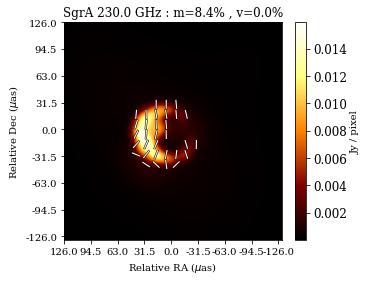

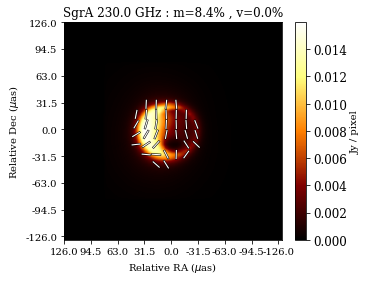

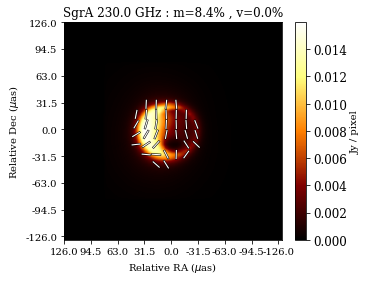

In [9]:
reco = handler.grad_desc(pol.final_init.flatten().copy(), 10**(-6), pol.final_func, pol.final_setting, maxit=1000)

reco2 = pol.final_op(reco)

out = wrapper.formatoutput(reco2)

out.display(plotp=True)
im.regrid_image(fov, npix+1).display(plotp=True)

Additionally to doing polarimetry, MrBeam also contains an operator that maps the polarized tuple (I, Q, U) onto the polarized closure trace ([Broderick and Pesce, 2020, ApJ, 904, 2, 126]). These traces are independent of calibration effects, in particular D-terms, but they also contain degeneracies (e.g. rottaion invariance in Poincare sphere). 

The ClosureTracePol class is a fully regpy operator. Hence, there is not only an implementation of the evaluation, but also of the derivative and the adjoint of the derivative. Thus, it is possible to use the closure traces as a calibration independent data fidelity term additionally to the option of using polarized visibilities. However, the minimization is very unstable. 

In [11]:
from imagingbase.operators.pol_trace import ClosureTracePol

clpol = ClosureTracePol(wrapper)
xtuple = wrapper.xtuple

print(clpol(xtuple))

[ 1.79795544e+02+4.57199622e+00j -1.70250421e+00+1.05580420e+00j
  1.68596029e+02-2.03455780e+00j -1.59434189e+00+1.21268378e+00j
  1.59256470e+02-5.74636296e+00j -1.49061509e+00+1.33790228e+00j
  1.51615919e+02-6.77050357e+00j -1.39741787e+00+1.43478675e+00j
  1.45553562e+02-5.38128242e+00j -1.31918500e+00+1.50688989e+00j
  1.40946774e+02-1.90127034e+00j -1.25877924e+00+1.55760609e+00j
  1.37637853e+02+3.35813302e+00j -1.21769126e+00+1.58987305e+00j
  1.35416658e+02+1.01631394e+01j -1.19636160e+00+1.60594726e+00j
  1.34010746e+02+1.84032807e+01j -1.19458957e+00+1.60723470e+00j
  1.33072968e+02+2.81073065e+01j -1.21192701e+00+1.59416285e+00j
  1.32158924e+02+3.94320060e+01j -1.24789820e+00+1.56610944e+00j
  1.30688173e+02+5.26245475e+01j -1.30189234e+00+1.52144902e+00j
  1.27887977e+02+6.79482749e+01j -1.37268835e+00+1.45781232e+00j
  1.22733365e+02+8.55537023e+01j -1.45778523e+00+1.37262919e+00j
  1.13922549e+02+1.05281868e+02j -1.55291724e+00+1.26390676e+00j
  9.99505718e+01+1.264156